# Shifts analysis

In [1]:
import argparse
import random
import sys
import yaml
from pathlib import Path
from typing import Any, Callable, Dict, Tuple, List

import numpy as np
from scipy.ndimage import shift
from skimage import exposure, io, registration, transform
from matplotlib import pyplot as plt
from tqdm import tqdm

%matplotlib inline

## Utilities

In [2]:
def load_data_img_as_array(path: Path) -> np.ndarray:
    img = np.expand_dims(io.imread(path, as_gray=False), axis=2)
    img = np.clip(img, a_min=None, a_max=pow(2, 14))
    img = exposure.rescale_intensity(
        img, in_range='uint14', out_range=(0.0, 1.0))
    return img

In [3]:
def load_obj_from_repr_file(path) -> Any:
    with open(path, 'r') as file_:
        ret = eval(file_.readline())
    return ret

In [4]:
def draw_xy_histograms(xy_shifts: Tuple[List[float], List[float]]):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(xy_shifts[0], 100)
    plt.subplot(1, 2, 2)
    plt.hist(xy_shifts[1], 100)
    plt.tight_layout()
    plt.show()

## Data gather

### Sentinel-2 artificial `s2ab_ab5`

#### In txt files

In s2ab_ab5 txt file first LR is registered with the HR. We collect shifts between the rest of LRs and this reference LR (which means HR too).

In [5]:
s2ab_ab5_txt_lr_xy_shifts = [[], []]
path = Path('../data/sentinel-2_artificial/')

limit = 1000
for i, hr_path in zip(tqdm(range(limit), position=0), path.glob('*/**/b8/**/hr.png')):
    hr = load_data_img_as_array(hr_path)

    translations_path = hr_path.parent/'lr_3x/translations.txt'
    translations = load_obj_from_repr_file(translations_path)

    for lr_idx in translations.keys():
        lr_xy_shifts = [-s for s in translations[lr_idx]]
        s2ab_ab5_txt_lr_xy_shifts[0].append(lr_xy_shifts[0])
        s2ab_ab5_txt_lr_xy_shifts[1].append(lr_xy_shifts[1])

100%|██████████| 1000/1000 [00:09<00:00, 107.20it/s]


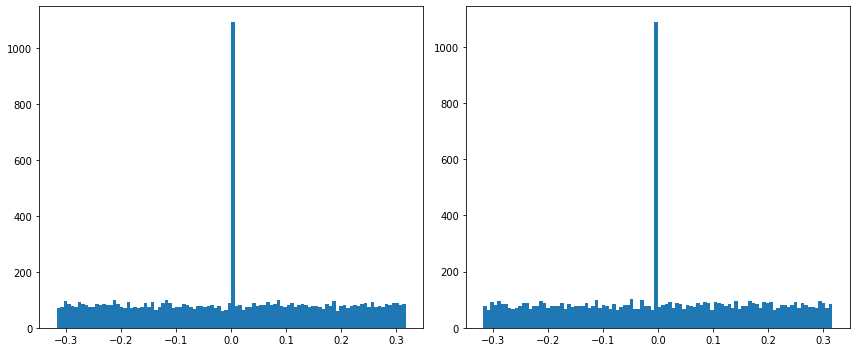

In [6]:
draw_xy_histograms(s2ab_ab5_txt_lr_xy_shifts)

#### In images

Here we test what should be the same. We take the exsiting HR img and check shifts between it and the LR images.

In [7]:
s2ab_ab5_img_hr_xy_shifts = [[], []]
path = Path('../data/sentinel-2_artificial/')

limit = 1000
for i, hr_path in zip(tqdm(range(limit), position=0), path.glob('*/**/b8/**/hr.png')):
    hr = load_data_img_as_array(hr_path)
    
    for lr_path in hr_path.parent.glob('lr_3x/*.png'):
        lr = load_data_img_as_array(lr_path)
        lr2hr = transform.resize(lr, hr.shape)
        s = registration.phase_cross_correlation(lr2hr, hr, upsample_factor=100)[0]
        s2ab_ab5_img_hr_xy_shifts[0].append(s[0])
        s2ab_ab5_img_hr_xy_shifts[1].append(s[1])

100%|██████████| 1000/1000 [1:49:42<00:00,  6.58s/it]


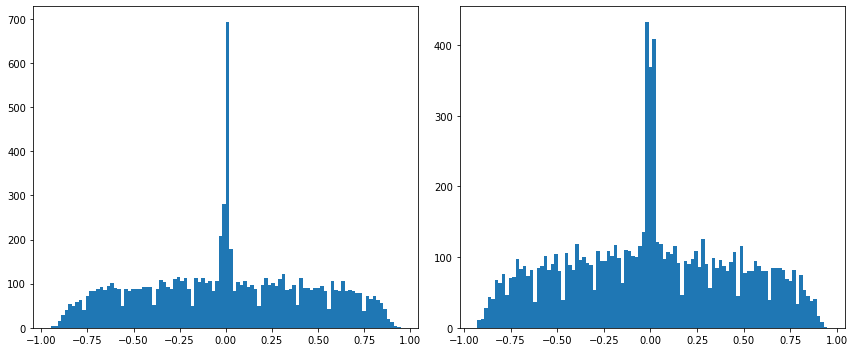

In [8]:
draw_xy_histograms(s2ab_ab5_img_hr_xy_shifts)

### Proba-V

Like we did for images in band 8 Sentinel-2 artificial, we check shifts between Proba-V HR and corresponding LRs

In [9]:
probav_hr_xy_shifts = [[], []]
path = Path('../data/proba-v/')

limit = 1000
for i, hr_path in zip(tqdm(range(limit), position=0), path.glob('train/*/*/hr.png')):
    hr = load_data_img_as_array(hr_path)
    
    for lr_path in hr_path.parent.glob('lr/*.png'):
        lr = load_data_img_as_array(lr_path)
        lr2hr = transform.resize(lr, hr.shape)
        s = registration.phase_cross_correlation(lr2hr, hr, upsample_factor=100)[0]
        probav_hr_xy_shifts[0].append(s[0])
        probav_hr_xy_shifts[1].append(s[1])

100%|██████████| 1000/1000 [2:10:30<00:00,  7.83s/it] 


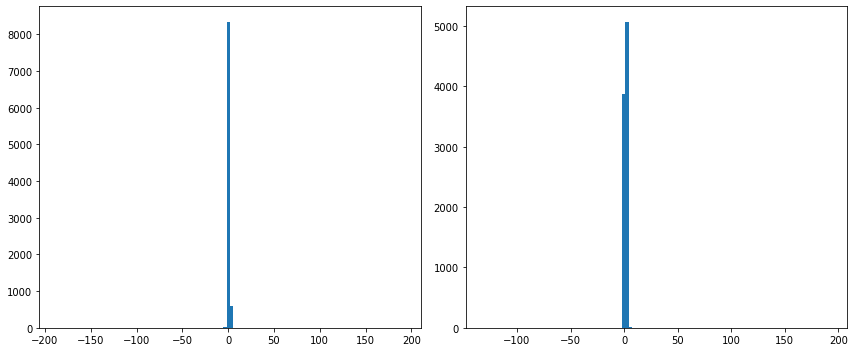

In [136]:
draw_xy_histograms(probav_hr_xy_shifts)

In [140]:
p_shifts = np.array(probav_hr_xy_shifts)

In [141]:
p_shifts.min(), p_shifts.max()

(-187.19, 191.76)

In [142]:
p_shifts.mean(axis=1)

array([0.76665444, 1.20256111])

In [143]:
np.all([p_shifts < 1, p_shifts > -1], axis=0).sum() / p_shifts.size

0.5697222222222222

In [144]:
np.all([p_shifts < 3, p_shifts > -3], axis=0).sum() / p_shifts.size

0.9756111111111111

In [145]:
np.all([p_shifts < 4, p_shifts > -4], axis=0).sum() / p_shifts.size

0.9946666666666667

In [146]:
p_xshifts_in_4 = p_shifts[0][np.all([p_shifts[0] < 4, p_shifts[0] > -4], axis=0)]
p_yshifts_in_4 = p_shifts[1][np.all([p_shifts[1] < 4, p_shifts[1] > -4], axis=0)]

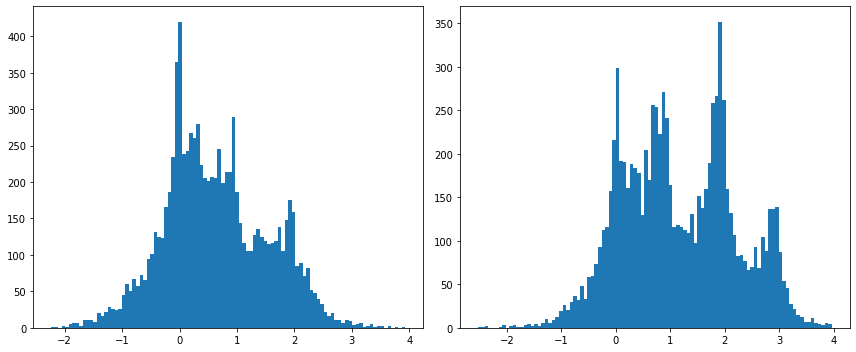

In [147]:
draw_xy_histograms((p_xshifts_in_4, p_yshifts_in_4))